In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
import scipy.stats as stats
import random

In [4]:
df=pd.read_csv('/content/train.csv')
pd.set_option('display.max_columns', None)
print(df.head(10))
pd.set_option('display.max_columns', 20)

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   
5   6          50       RL         85.0    14115   Pave   NaN      IR1   
6   7          20       RL         75.0    10084   Pave   NaN      Reg   
7   8          60       RL          NaN    10382   Pave   NaN      IR1   
8   9          50       RM         51.0     6120   Pave   NaN      Reg   
9  10         190       RL         50.0     7420   Pave   NaN      Reg   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl

In [5]:
columns_to_process = ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu','GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
print("Before replacement:")
print(df[columns_to_process].isna().sum())

for column in columns_to_process:
    df[column] = df[column].fillna("None")

print("\nAfter replacement:")
print(df[columns_to_process].isna().sum())

Before replacement:
Alley           1369
MasVnrType         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
FireplaceQu      690
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

After replacement:
Alley           0
MasVnrType      0
BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
FireplaceQu     0
GarageType      0
GarageFinish    0
GarageQual      0
GarageCond      0
PoolQC          0
Fence           0
MiscFeature     0
dtype: int64


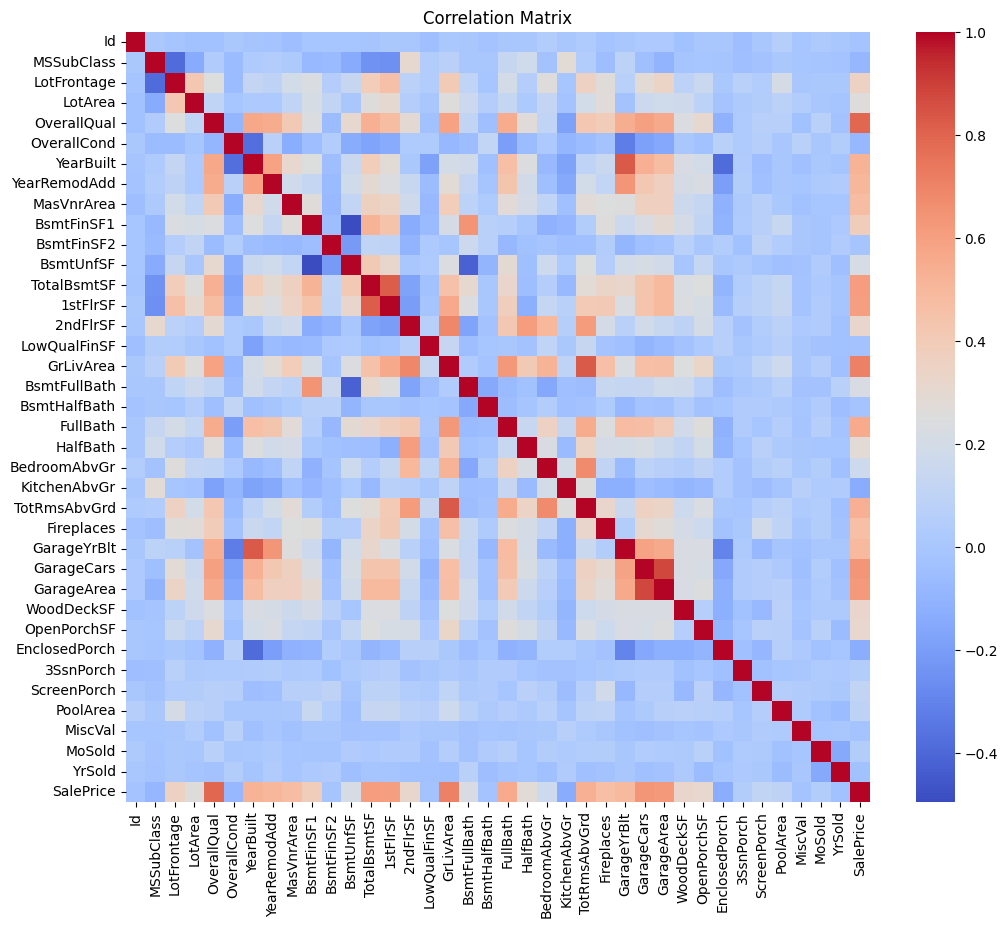

In [7]:
# Calculate the correlation matrix (for numerical data)
categorical_columns = df.select_dtypes(include=['object']).columns
numerical_df = df.drop(columns=categorical_columns)
correlation_matrix = numerical_df.corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

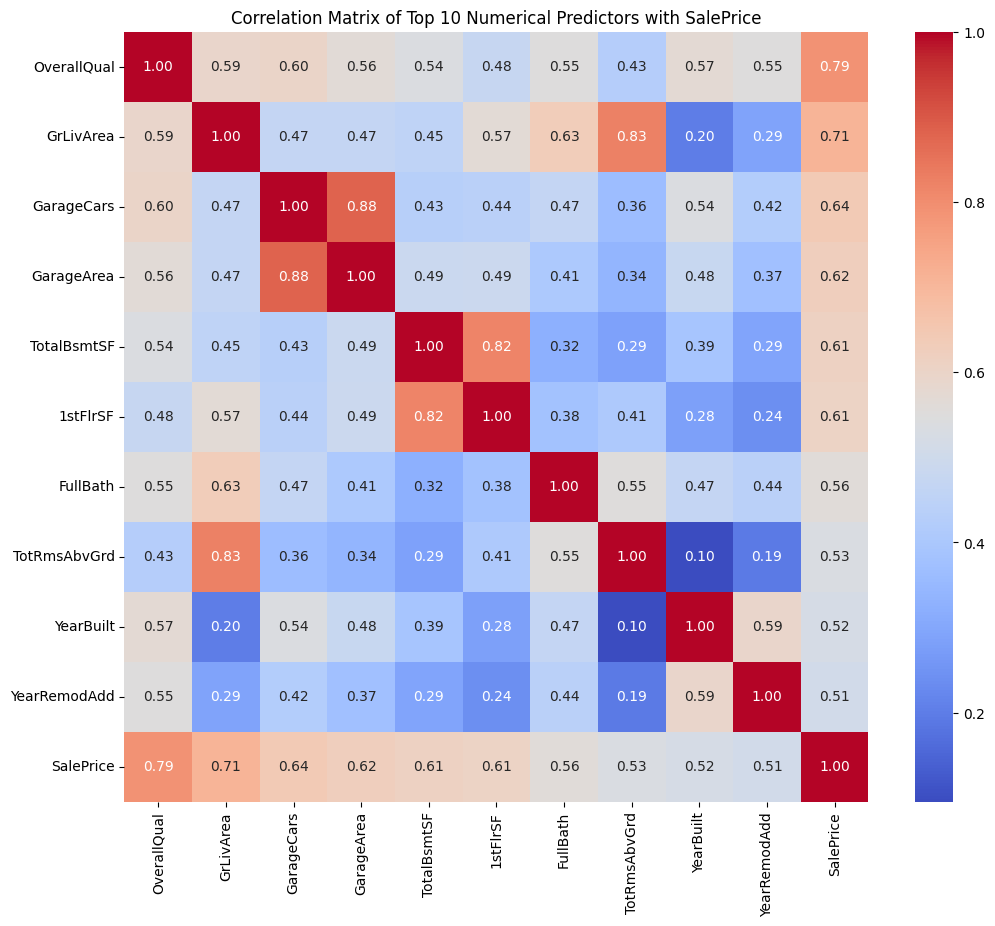

In [8]:
# Select the top 10 predictors with the highest correlation to 'SalePrice'
top_10_predictors = correlation_matrix['SalePrice'].sort_values(ascending=False).head(11).index[1:]

# Extract the subset of the DataFrame with only the selected predictors
numerical_df_subset = numerical_df[top_10_predictors].copy()
#including saleprice
numerical_df_subset['SalePrice'] = numerical_df['SalePrice'].copy()
# Plot the correlation matrix for the selected predictors
plt.figure(figsize=(12, 10))
sns.heatmap(numerical_df_subset.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Top 10 Numerical Predictors with SalePrice')
plt.show()

In [9]:
numerical_df_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   OverallQual   1460 non-null   int64
 1   GrLivArea     1460 non-null   int64
 2   GarageCars    1460 non-null   int64
 3   GarageArea    1460 non-null   int64
 4   TotalBsmtSF   1460 non-null   int64
 5   1stFlrSF      1460 non-null   int64
 6   FullBath      1460 non-null   int64
 7   TotRmsAbvGrd  1460 non-null   int64
 8   YearBuilt     1460 non-null   int64
 9   YearRemodAdd  1460 non-null   int64
 10  SalePrice     1460 non-null   int64
dtypes: int64(11)
memory usage: 125.6 KB


In [10]:
count_partial = df['SaleCondition'].value_counts()['Partial']
print(f'Number of data points with "Partial": {count_partial}')

Number of data points with "Partial": 125


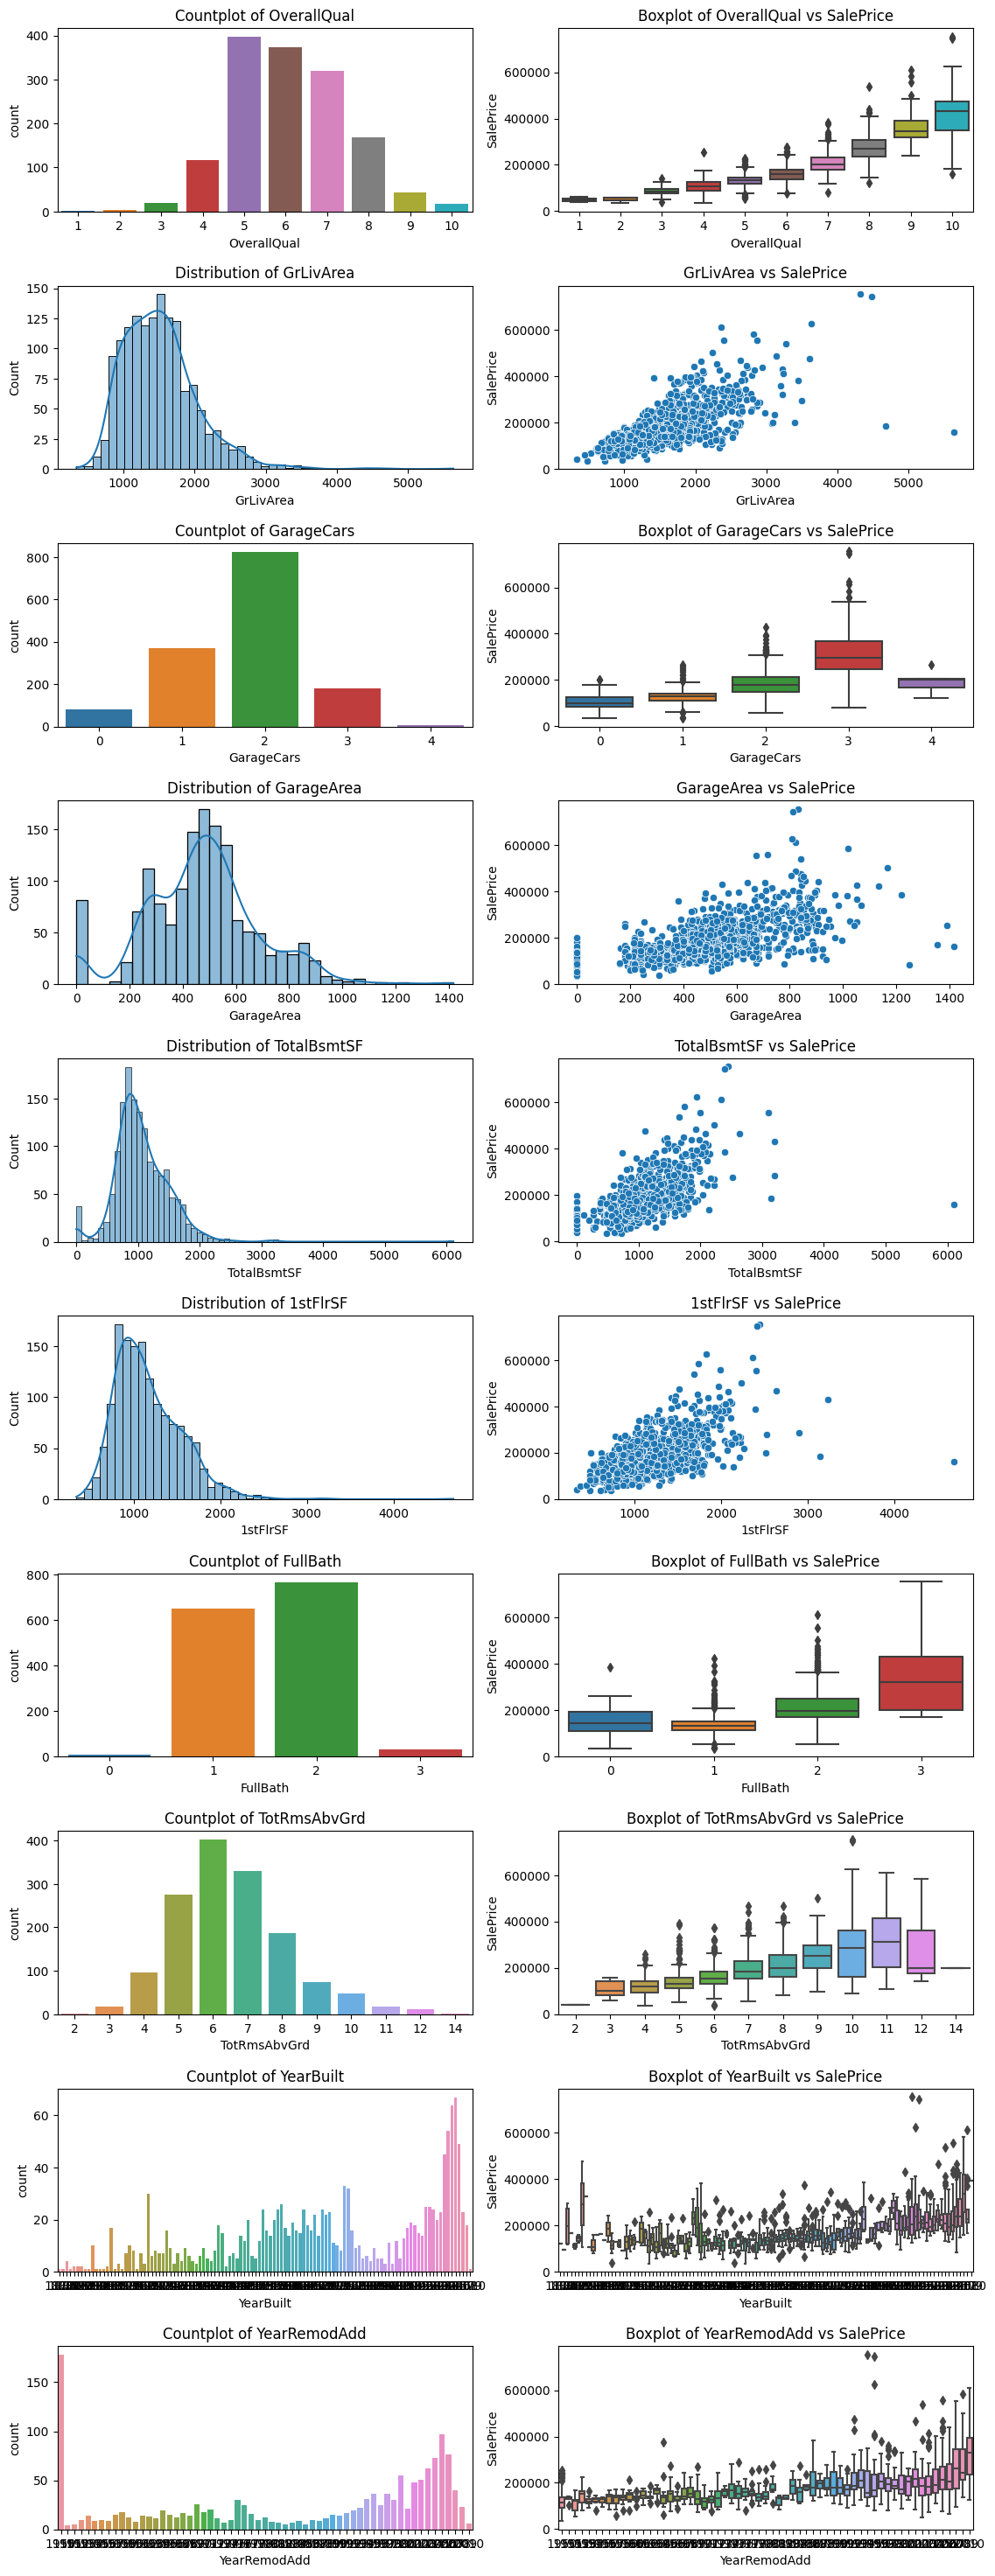

In [11]:
# Drop 'SalePrice' column
numerical_df_subset_no_saleprice = numerical_df_subset.drop('SalePrice', axis=1)

# Specify variables for scatterplots
scatterplot_variables = ['GrLivArea', 'GarageArea', 'TotalBsmtSF', '1stFlrSF']  # Add your specific variable names

# Set up subplots
fig, axes = plt.subplots(nrows=len(numerical_df_subset_no_saleprice.columns), ncols=2, figsize=(12, 3 * len(numerical_df_subset_no_saleprice.columns)))
fig.tight_layout(pad=4.0)

# Iterate through numerical variables
for i, variable in enumerate(numerical_df_subset_no_saleprice.columns):
    # Determine the plot type based on the variable
    if variable in scatterplot_variables:
        # Scatterplot on the right
        sns.scatterplot(x=variable, y='SalePrice', data=numerical_df_subset, ax=axes[i, 1])
        axes[i, 1].set_title(f'{variable} vs SalePrice')

        # Histogram on the left
        sns.histplot(numerical_df_subset_no_saleprice[variable], ax=axes[i, 0], kde=True)
        axes[i, 0].set_title(f'Distribution of {variable}')
    else:
        # Countplot on the left for categorical-like variables
        sns.countplot(x=variable, data=numerical_df_subset_no_saleprice, ax=axes[i, 0])
        axes[i, 0].set_title(f'Countplot of {variable}')

        # Boxplot on the right
        sns.boxplot(x=variable, y='SalePrice', data=numerical_df_subset, ax=axes[i, 1])
        axes[i, 1].set_title(f'Boxplot of {variable} vs SalePrice')

plt.show()

In [12]:
# Generate a random integer
random_seed = random.randint(1, 1000)

#But first, splitting the data!
X = numerical_df_subset.drop('SalePrice', axis=1)  # Features
y = numerical_df_subset['SalePrice']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = random_seed)

#examine shape of new subsets
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1168, 10)
Shape of y_train: (1168,)
Shape of X_test: (292, 10)
Shape of y_test: (292,)


R-squared (R2): 0.7990
Mean Squared Error (MSE): 1401237710.2754


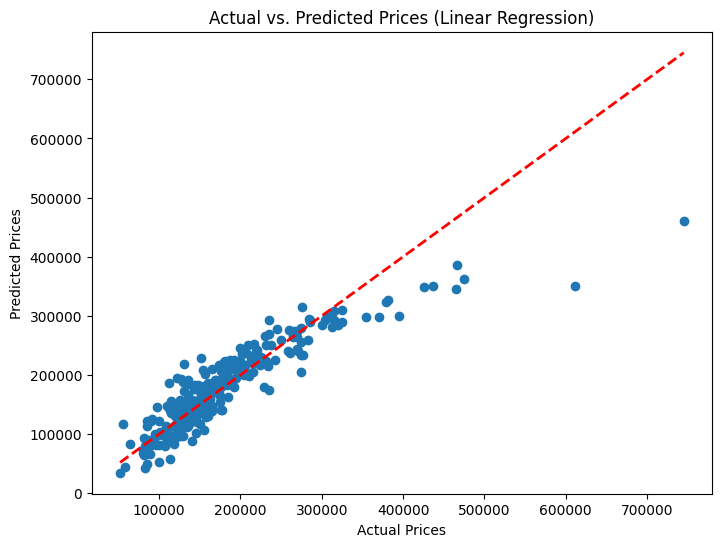

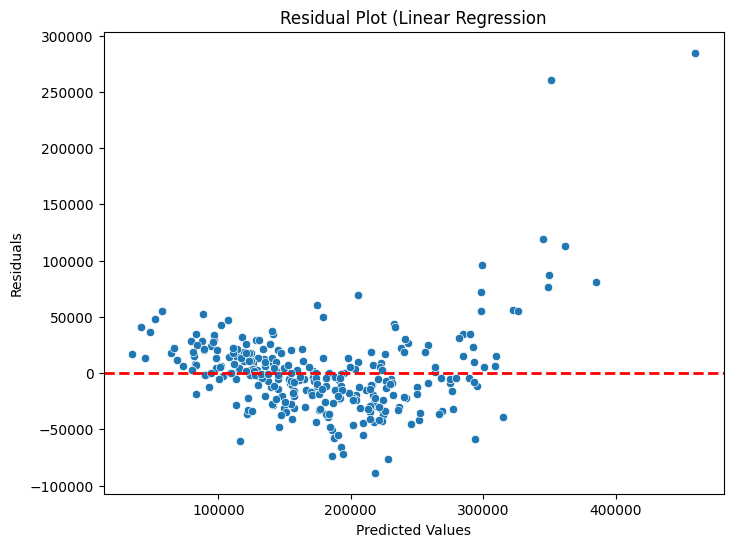

In [13]:
#Initialize linear reg model
model = LinearRegression()

#Train model
model.fit(X_train, y_train)

#predict
y_pred = model.predict(X_test)

#Evaluate
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'R-squared (R2): {r2:.4f}')
print(f'Mean Squared Error (MSE): {mse:.4f}')

# Plot the predicted vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)
plt.title('Actual vs. Predicted Prices (Linear Regression)')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()

#residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.title('Residual Plot (Linear Regression')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,None,Reg,Lvl,AllPub,...,0,None,MnPrv,None,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,None,Reg,Lvl,AllPub,...,0,None,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2010,WD,Normal,142125


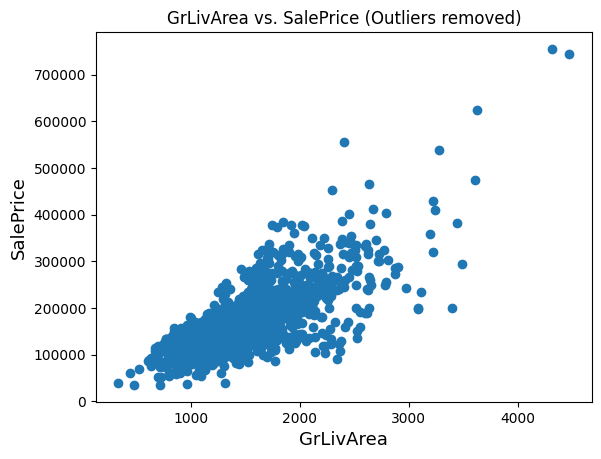

In [14]:
subset_no_partial = df[df['SaleCondition'] != 'Partial']
display(subset_no_partial)
subset_no_outliers = subset_no_partial[top_10_predictors].copy()
#including saleprice
subset_no_outliers['SalePrice'] = subset_no_partial['SalePrice'].copy()

#Check the new plot
fig, ax = plt.subplots()
ax.scatter(subset_no_outliers['GrLivArea'], subset_no_outliers['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.title('GrLivArea vs. SalePrice (Outliers removed)')
plt.show()

R-squared (R2): 0.8144
Mean Squared Error (MSE): 1163825307.0775


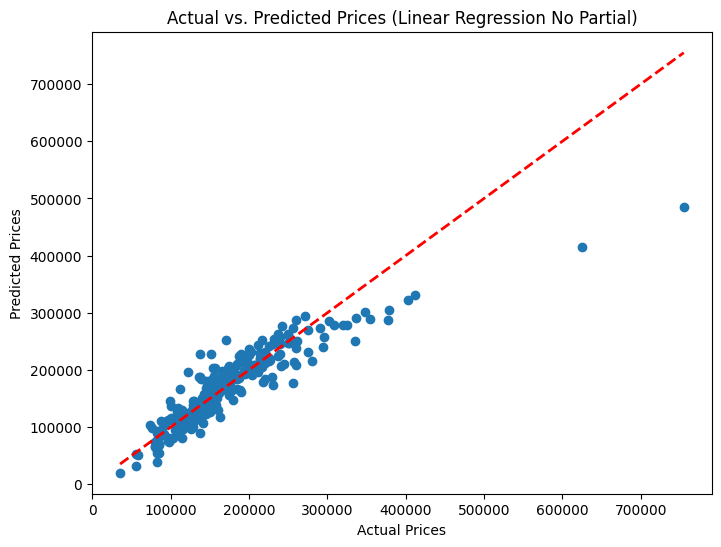

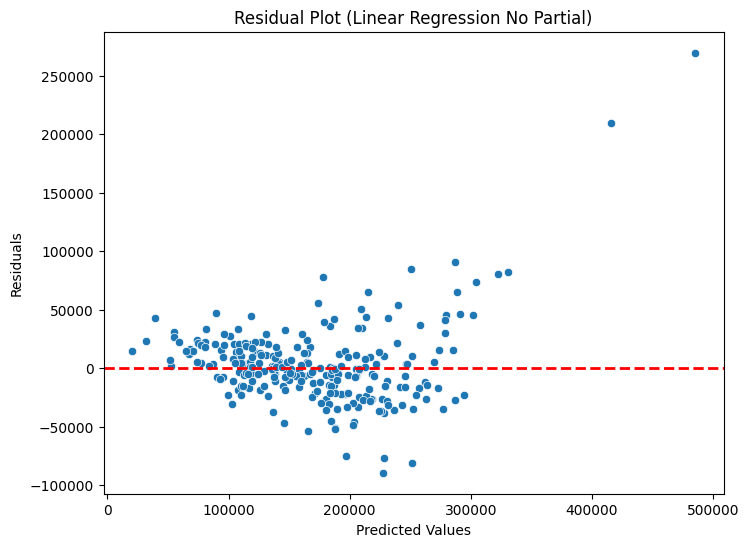

In [15]:
X = subset_no_outliers.drop('SalePrice', axis=1)  # Features
y = subset_no_outliers['SalePrice']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = random_seed)
#Initialize linear reg model
model = LinearRegression()

#Train model
model.fit(X_train, y_train)

#predict
y_pred = model.predict(X_test)

#Evaluate
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'R-squared (R2): {r2:.4f}')
print(f'Mean Squared Error (MSE): {mse:.4f}')

# Plot the predicted vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)
plt.title('Actual vs. Predicted Prices (Linear Regression No Partial)')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()

#residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.title('Residual Plot (Linear Regression No Partial)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

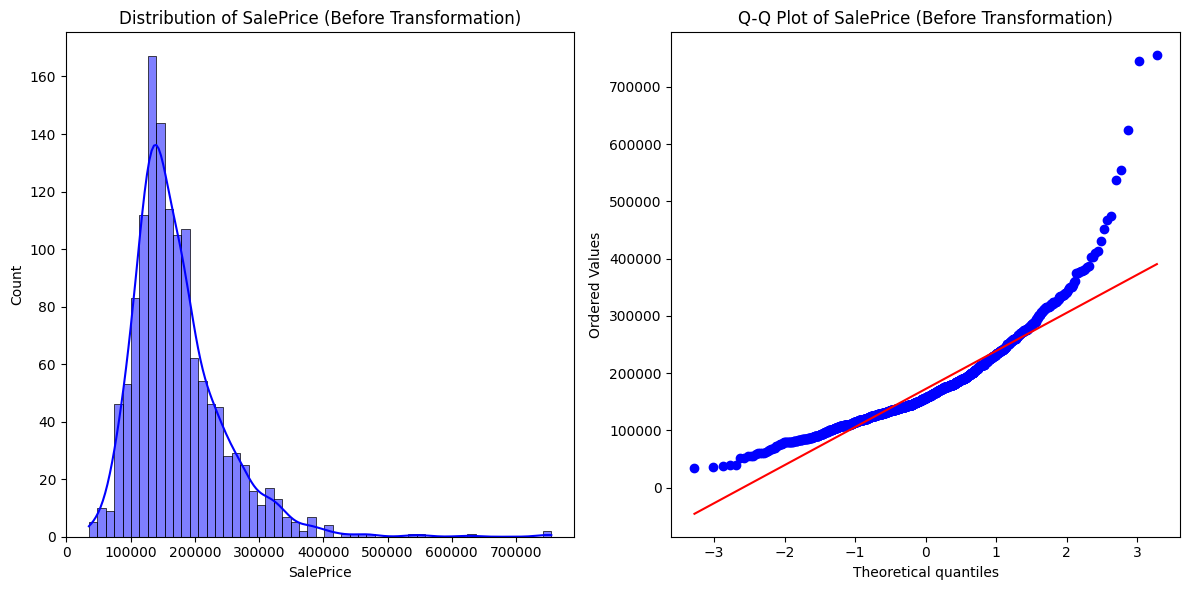

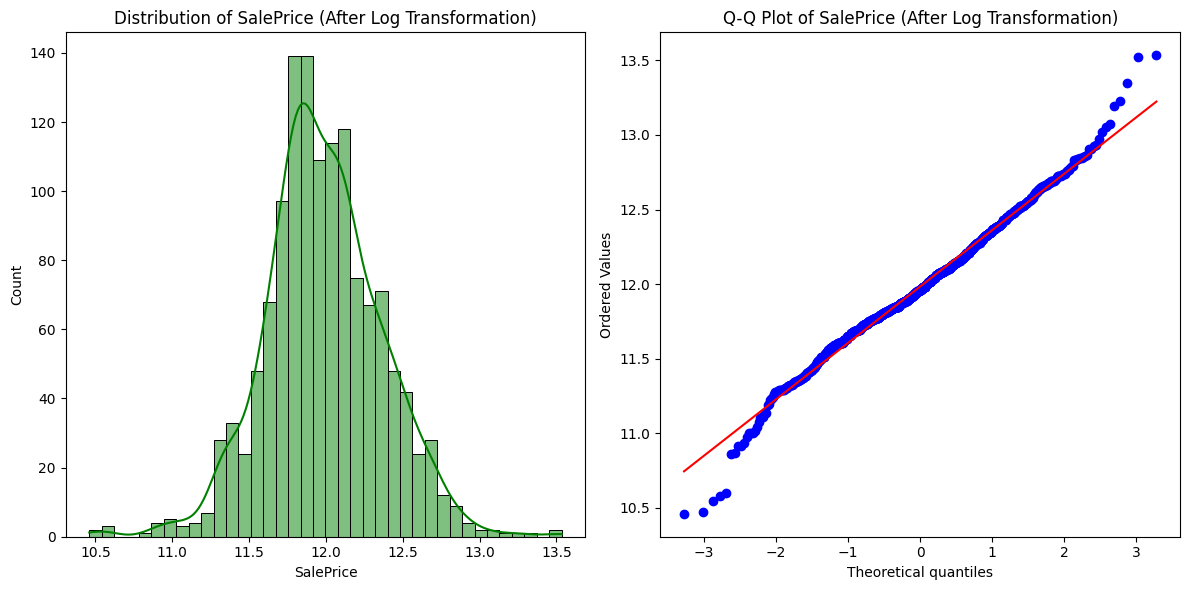

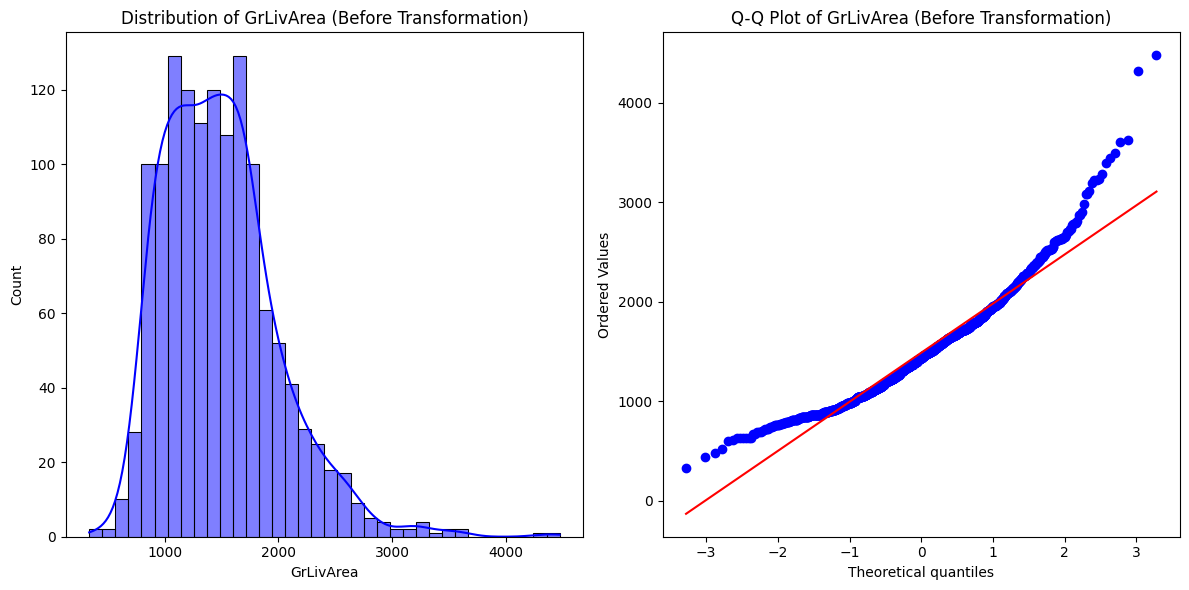

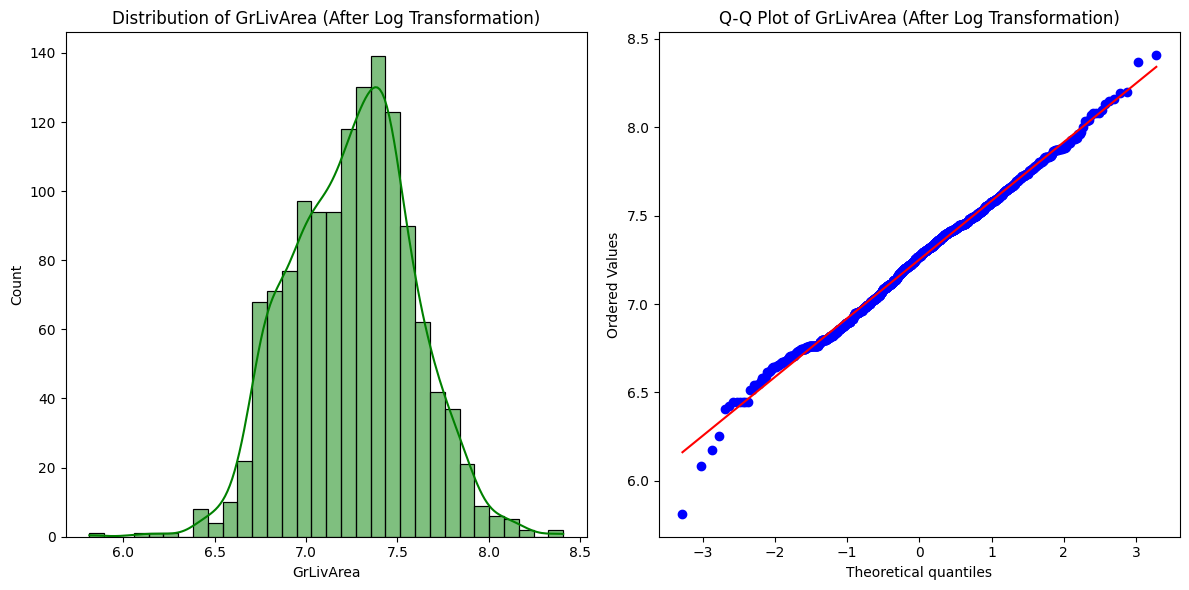

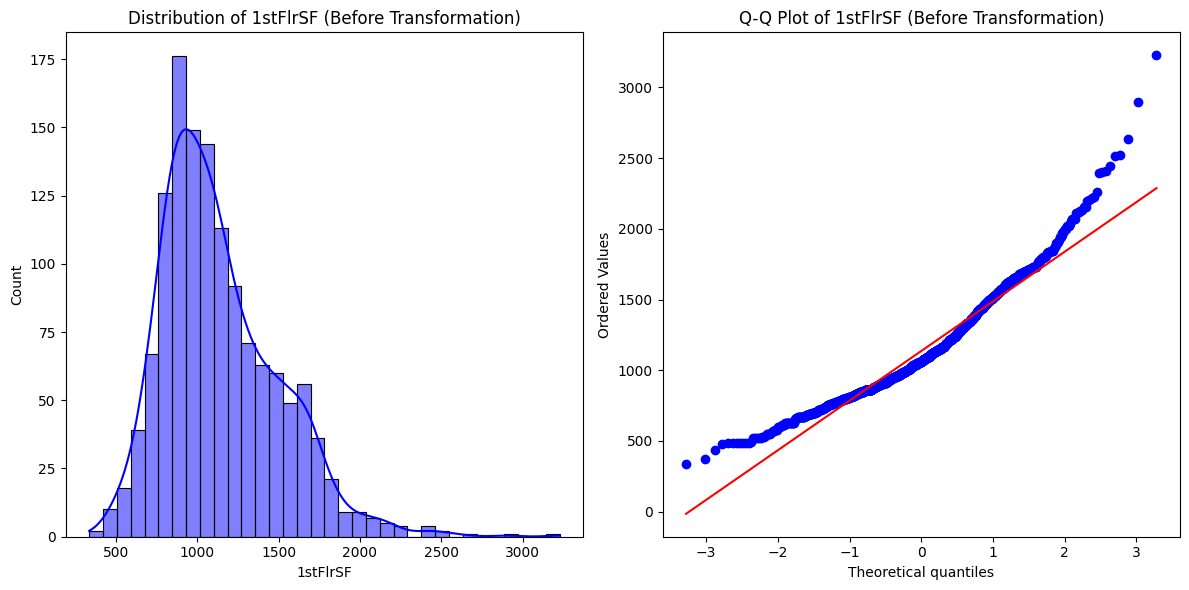

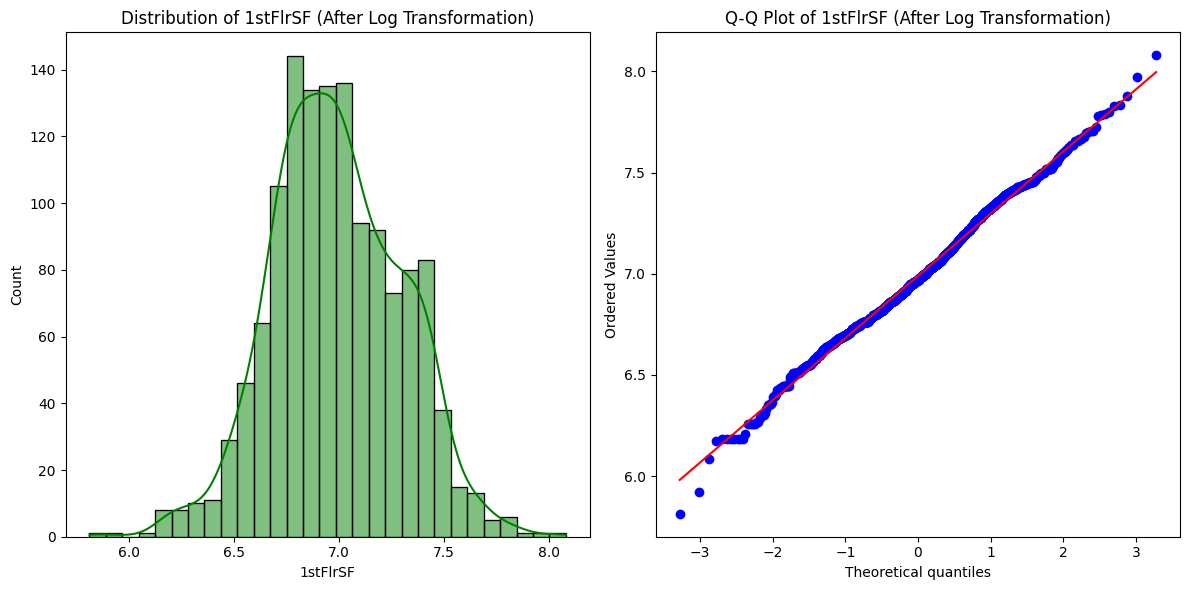

In [16]:
selected_columns = ['SalePrice', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', '1stFlrSF']

# Create a new DataFrame for log-transformed variables
no_outliers_log = subset_no_outliers.copy()

# Loop through selected columns and apply log transformation
for column in selected_columns:
    # Skip columns that contain non-positive values
    if np.any(subset_no_outliers[column] <= 0):
        continue

    # Log transformation
    no_outliers_log[column] = np.log1p(subset_no_outliers[column])

    # Plot distribution and Q-Q plot before transformation
    plt.figure(figsize=(12, 6))

    # Distribution plot before transformation
    plt.subplot(1, 2, 1)
    sns.histplot(subset_no_outliers[column], kde=True, color='blue')
    plt.title(f'Distribution of {column} (Before Transformation)')

    # Q-Q plot before transformation
    plt.subplot(1, 2, 2)
    stats.probplot(subset_no_outliers[column], dist='norm', plot=plt)
    plt.title(f'Q-Q Plot of {column} (Before Transformation)')

    plt.tight_layout()
    plt.show()

    # Plot distribution and Q-Q plot after transformation
    plt.figure(figsize=(12, 6))

    # Distribution plot after transformation
    plt.subplot(1, 2, 1)
    sns.histplot(no_outliers_log[column], kde=True, color='green')
    plt.title(f'Distribution of {column} (After Log Transformation)')

    # Q-Q plot after transformation
    plt.subplot(1, 2, 2)
    stats.probplot(no_outliers_log[column], dist='norm', plot=plt)
    plt.title(f'Q-Q Plot of {column} (After Log Transformation)')

    plt.tight_layout()
    plt.show()

R-squared (R2): 0.8709
Mean Squared Error (MSE): 0.0209


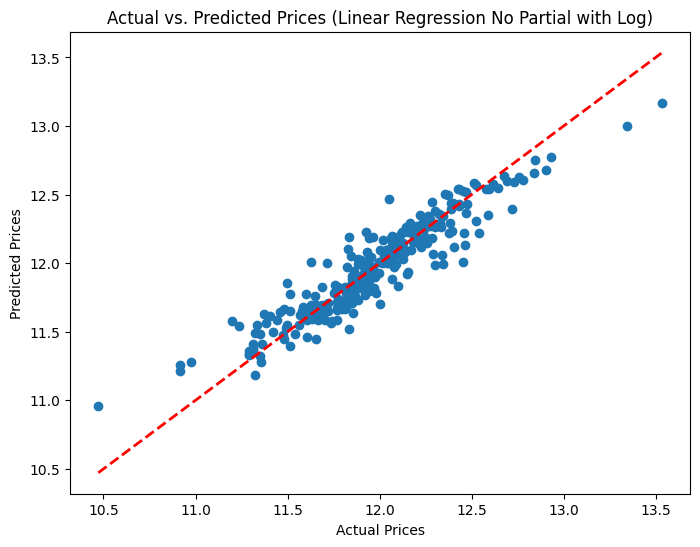

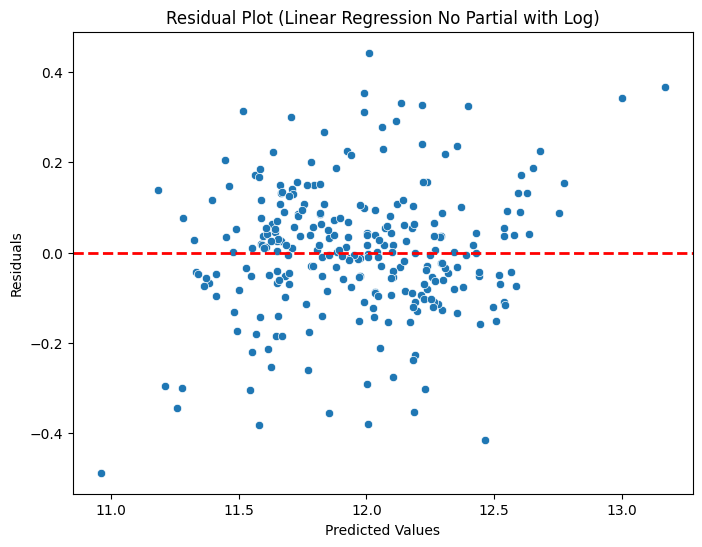

In [17]:
X = no_outliers_log.drop('SalePrice', axis=1)  # Features
y = no_outliers_log['SalePrice']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = random_seed)
#Initialize linear reg model
model = LinearRegression()

#Train model
model.fit(X_train, y_train)

#predict
y_pred = model.predict(X_test)

#Evaluate
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'R-squared (R2): {r2:.4f}')
print(f'Mean Squared Error (MSE): {mse:.4f}')

# Plot the predicted vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)
plt.title('Actual vs. Predicted Prices (Linear Regression No Partial with Log)')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()

#residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.title('Residual Plot (Linear Regression No Partial with Log)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

9/9 [==============================] - 0s 2ms/step
Mean Squared Error (MSE): 1375331573.4515
R-squared (R2): 0.7807


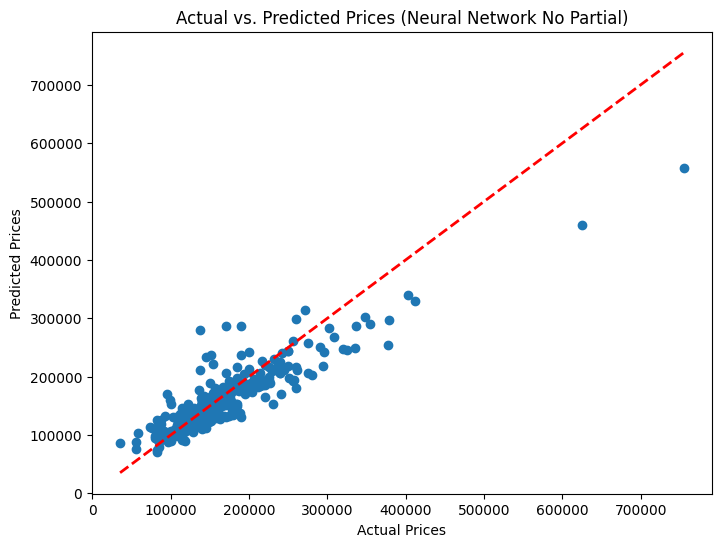

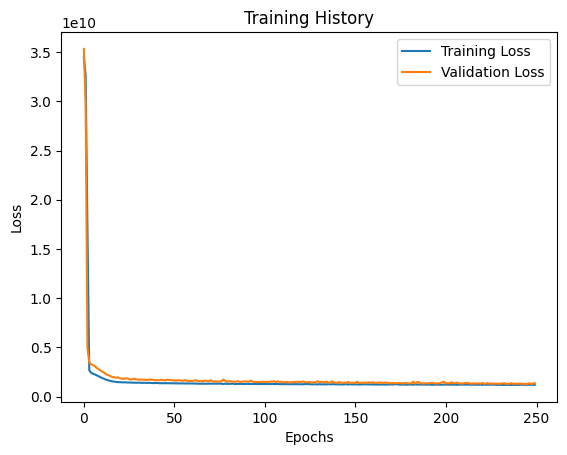

In [18]:
X = subset_no_outliers.drop('SalePrice', axis=1)
y = subset_no_outliers['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

# Build the neural network model with two hidden layers
model = Sequential()
model.add(Dense(30, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(20, activation='relu'))  # Second hidden layer
model.add(Dense(10, activation='relu'))  # Second hidden layer
model.add(Dense(5, activation='relu'))  # third hidden layer
model.add(Dense(1, activation='linear'))  # Output layer with linear activation for regression

# Using the Adam optimizer and Mean Squared Error loss
model.compile(optimizer='adam', loss='mean_squared_error')

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=250, batch_size=15, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=0)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'R-squared (R2): {r2:.4f}')

# Plot the predicted vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)
plt.title('Actual vs. Predicted Prices (Neural Network No Partial)')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()

# Plot the training history (loss over epochs)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

9/9 [==============================] - 0s 2ms/step
Mean Squared Error (MSE): 1365248195.3562
R-squared (R2): 0.7823


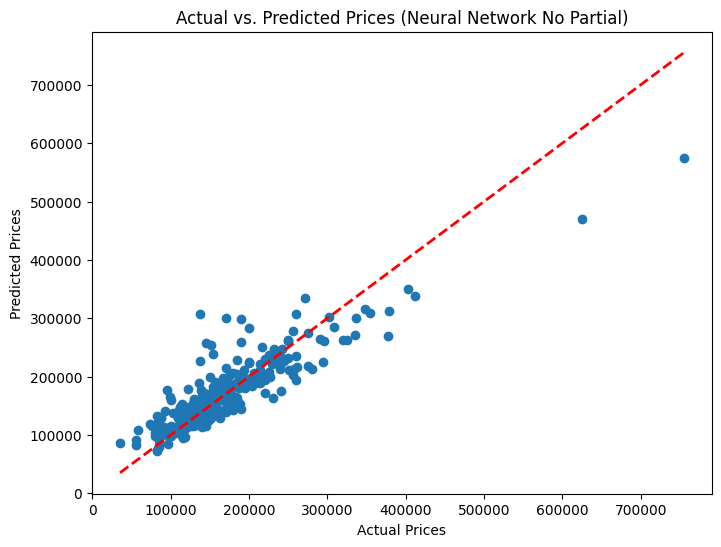

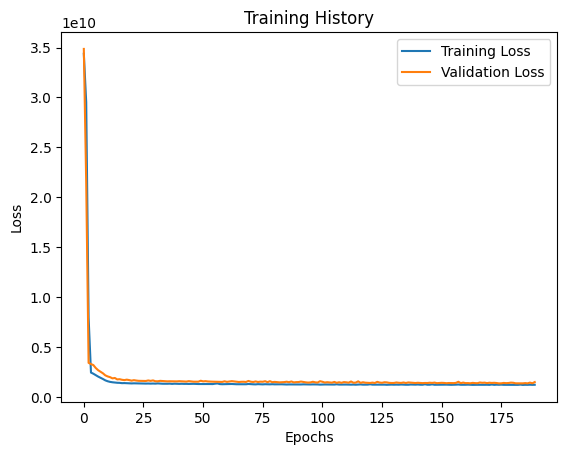

In [19]:
X = subset_no_outliers.drop('SalePrice', axis=1)
y = subset_no_outliers['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

# Build the neural network model with two hidden layers
model = Sequential()
model.add(Dense(30, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(20, activation='relu'))  # Second hidden layer
model.add(Dense(10, activation='relu'))  # Second hidden layer
model.add(Dense(5, activation='relu'))  # third hidden layer
model.add(Dense(1, activation='linear'))  # Output layer with linear activation for regression

# Using the Adam optimizer and Mean Squared Error loss
model.compile(optimizer='adam', loss='mean_squared_error')

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=250, batch_size=15, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=0)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'R-squared (R2): {r2:.4f}')

# Plot the predicted vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)
plt.title('Actual vs. Predicted Prices (Neural Network No Partial)')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()

# Plot the training history (loss over epochs)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
print(y_pred)

[[146709.   ]
 [110266.62 ]
 [239018.58 ]
 [114036.05 ]
 [178268.48 ]
 [237245.17 ]
 [102376.99 ]
 [194031.8  ]
 [161025.81 ]
 [312189.97 ]
 [177816.14 ]
 [234778.14 ]
 [204578.97 ]
 [163595.75 ]
 [122213.77 ]
 [223204.14 ]
 [113869.84 ]
 [183386.39 ]
 [253988.33 ]
 [187053.08 ]
 [139583.17 ]
 [147536.97 ]
 [186537.86 ]
 [ 86638.29 ]
 [103050.26 ]
 [155470.73 ]
 [163739.62 ]
 [179657.22 ]
 [113274.07 ]
 [298515.66 ]
 [188805.48 ]
 [227103.88 ]
 [234667.22 ]
 [193432.12 ]
 [123621.71 ]
 [141954.69 ]
 [137997.83 ]
 [147296.61 ]
 [114112.84 ]
 [131155.25 ]
 [215668.45 ]
 [129104.836]
 [184704.38 ]
 [169393.25 ]
 [178342.11 ]
 [161420.19 ]
 [130192.695]
 [214655.08 ]
 [264296.03 ]
 [176765.48 ]
 [173929.9  ]
 [155198.58 ]
 [145816.   ]
 [135150.38 ]
 [168830.67 ]
 [130617.33 ]
 [120226.83 ]
 [153583.3  ]
 [130565.484]
 [192517.   ]
 [202438.52 ]
 [250831.52 ]
 [182784.6  ]
 [190029.53 ]
 [207805.27 ]
 [202518.62 ]
 [152730.69 ]
 [247840.23 ]
 [337469.34 ]
 [190112.69 ]
 [199241.3  ]
 [1739